# Imports

In [1]:
import contextlib
import os
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry
import seaborn as sns
from sqlalchemy import create_engine

# Constants

In [2]:
def check_given_var(env_var_str: str) -> str:
    """
    Check if the given environment variable is set and return its value.

    Args:
        env_var_str (str): The name of the environment variable to check.

    Returns:
        str: The value of the environment variable.

    Raises:
        AssertionError: If the environment variable is not found.
    """

    env_var = os.getenv(env_var_str)
    assert (
        env_var is not None
    ), f"{env_var_str} is required but not found in environment variables"
    return env_var


def check_env_vars() -> (str, str, str, str):  # type: ignore
    user = check_given_var("DBL_USER")
    database = check_given_var("DBL_DATABASE")
    password = check_given_var("DBL_PASSWORD")
    host = check_given_var("DBL_HOST")
    return user, database, password, host


USER, DATABASE, PASSWORD, HOST = check_env_vars()
# USER, DATABASE = "nezox2um_test", "nezox2um_test"

QUERY_ALL = """
SELECT 
    Users.user_id AS user_id, 
    Users.creation_time AS user_creation_time, 
    Users.verified,
    Users.followers_count,
    Users.friends_count,
    Users.statuses_count,
    Users.default_profile,
    Users.default_profile_image,
    Tweets.creation_time AS tweet_creation_time,
    Tweets.tweet_id,
    Tweets.full_text,
    Tweets.lang,
    Tweets.country_code,
    Tweets.favorite_count,
    Tweets.retweet_count,
    Tweets.possibly_sensitive,
    Tweets.replied_tweet_id,
    Tweets.reply_count,
    Tweets.quoted_status_id,
    Tweets.quote_count
FROM Users
INNER JOIN Tweets ON Users.user_id = Tweets.user_id;
"""

QUERY_REPLY = """
SELECT 
    t1.tweet_id AS tweet_id,
    t1.creation_time AS tweet_creation_time,
    t1.user_id AS user_id,
    t2.tweet_id AS original_tweet_id,
    t2.creation_time AS original_tweet_creation_time,
    t2.user_id AS original_user_id
FROM 
    Tweets t1
INNER JOIN 
    Tweets t2
ON 
    t1.replied_tweet_id = t2.tweet_id;
"""

DTYPES = {
"user_id": "object",
"user_creation_time": "datetime64[ns]",
"verified": "bool",
"followers_count": "int32",
"friends_count": "int32",
"statuses_count": "int32",
"default_profile": "bool",
"default_profile_image": "bool",
"tweet_creation_time": "datetime64[ns]",
"tweet_id": "object",
"full_text": "object",
"lang": "category",
"country_code": "category",
"favorite_count": "int32",
"retweet_count": "int32",
"possibly_sensitive": "bool",
"replied_tweet_id": "object",
"reply_count": "int32",
"quoted_status_id": "object",
"quote_count": "int32",
}

COMPANY_NAME_TO_ID = {
    "Klm": "56377143",
    "Air France": "106062176",
    "British Airways": "18332190",
    "American Air": "22536055",
    "Lufthansa": "124476322",
    "Air Berlin": "26223583",
    "Air Berlin assist": "2182373406",
    "easyJet": "38676903",
    "Ryanair": "1542862735",
    "Singapore Airlines": "253340062",
    "Qantas": "218730857",
    "Etihad Airways": "45621423",
    "Virgin Atlantic": "20626359",
}

COMPANY_ID_TO_NAME = {v: k for k, v in COMPANY_NAME_TO_ID.items()}

# Helper functions

In [3]:
def blob_to_datetime(blob: str) -> pd.Timestamp:
    return pd.to_datetime(blob)



def get_local_data(query: str, path: str, dtype: bool = True) -> pd.DataFrame:
    # Connect to the SQLite database using a context manager
    with sqlite3.connect(path) as connection:
        # Read the data into a DataFrame
        if dtype:
            df = pd.read_sql_query(query, connection,
                                   dtype={k: v for k, v in DTYPES.items() if k not in ("tweet_creation_time", "user_creation_time")},
                                   index_col='tweet_id')
            df['tweet_creation_time'] = pd.to_datetime(df['tweet_creation_time'])
            df['user_creation_time'] = pd.to_datetime(df['user_creation_time'])
        else:
            df = pd.read_sql_query(query, connection)
    
    return df


def fetch_data(query: str, dtype: bool = True) -> pd.DataFrame:
    engine = create_engine(f"mysql://{USER}:{PASSWORD}@{HOST}:3306/{DATABASE}")
    if dtype:
        return pd.read_sql_query(query, engine,
                                 dtype=DTYPES, index_col='tweet_id')
    return pd.read_sql_query(query, engine)


def get_size_of(size_bytes: float | int) -> str:
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    # Using numpy to calculate the logarithm base 1024
    i = int(np.floor(np.log(size_bytes) / np.log(1024)))
    # Using numpy to calculate power of 1024
    p = np.power(1024, i)
    # Computing the size division
    s = round(size_bytes / p, 2)
    return f"{s} {size_name[i]}"


def identify_dtype(column: pd.Series) -> str:
    """
    Identifies the most suitable data type for a pandas Series without loss of information.

    Args:
    column (pd.Series): The pandas Series for which the data type needs to be identified.

    Returns:
    str: Suggested data type as a string.
    """
    # Check if the column can be converted to numeric types (int or float)
    if pd.api.types.is_numeric_dtype(column):
        if not pd.to_numeric(column.dropna(), errors='coerce').notna().all():
            return 'object'  # Fallback if numeric conversion fails

        if not (column.dropna() % 1 == 0).all():
            return 'float'
        # Check range to decide between int types
        min_val, max_val = column.min(), column.max()
        if np.iinfo(np.int8).min <= min_val <= np.iinfo(np.int8).max and max_val <= np.iinfo(np.int8).max:
            return 'int8'
        elif np.iinfo(np.int16).min <= min_val <= np.iinfo(np.int16).max and max_val <= np.iinfo(np.int16).max:
            return 'int16'
        elif np.iinfo(np.int32).min <= min_val <= np.iinfo(np.int32).max and max_val <= np.iinfo(np.int32).max:
            return 'int32'
        else:
            return 'int64'
    # Check if the column can be converted to datetime
    with contextlib.suppress(ValueError, TypeError):
        pd.to_datetime(column)
        return 'datetime'
    # Check if the column should be categorical
    if pd.api.types.is_object_dtype(column):
        num_unique_values = len(column.unique())
        num_total_values = len(column)
        if num_unique_values / num_total_values < 0.5:
            return 'category'

    # Default to object type if none of the above conditions are met
    return 'object'


def get_full_language_name(language_code: str,
                           default: str="Undefined Language") -> str:
    """
    Convert a two-letter language code (ISO 639-1) to its full language name.
    
    Parameters:
    language_code (str): The two-letter ISO 639-1 language code.
    
    Returns:
    str: The full name of the language or a message indicating the code was not found.
    """
    if language_code=="Other languages":
        return language_code
    language = pycountry.languages.get(alpha_2=language_code, default=default)
    if language != default:
        language = language.name
    return language


def get_country_name(country_code: str, default: str="Unknown Country") -> str:
    """
    Convert a two-letter country code (ISO 3166-1 alpha-2|) to its full country name.
    
    Parameters:
    country_code (str): The two-letter ISO 3166-1 alpha-2 country code.
    
    Returns:
    str: The full name of the country or a message indicating the code was not found.
    """
    country = pycountry.countries.get(alpha_2=country_code, default=default)
    if country != default:
        country = country.name
    return country

# Loading

In [4]:
# Server
# test_data = fetch_data(QUERY_ALL)
# df_reply = fetch_data(QUERY_REPLY, dtype=False).set_index("tweet_id")
# Local
path =  os.path.join(
    os.path.dirname(
        os.path.dirname(
            os.getcwd()
            )
        ),
    "data_processed", "local_backup.db")
path
test_data = get_local_data(QUERY_ALL, path)
df_reply = get_local_data(QUERY_REPLY, path, dtype=False).set_index("tweet_id")

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6148105 entries, 1131172858951024641 to 1244696713765564416
Data columns (total 19 columns):
 #   Column                 Dtype              
---  ------                 -----              
 0   user_id                object             
 1   user_creation_time     datetime64[ns, UTC]
 2   verified               bool               
 3   followers_count        int32              
 4   friends_count          int32              
 5   statuses_count         int32              
 6   default_profile        bool               
 7   default_profile_image  bool               
 8   tweet_creation_time    datetime64[ns, UTC]
 9   full_text              object             
 10  lang                   category           
 11  country_code           category           
 12  favorite_count         int32              
 13  retweet_count          int32              
 14  possibly_sensitive     bool               
 15  replied_tweet_id       object            

In [6]:
get_size_of(test_data.memory_usage(index=True, deep=True).sum())

'3.34 GB'

In [7]:
test_data.describe()

,followers_count,friends_count,statuses_count,favorite_count,retweet_count,reply_count,quote_count
count,6.148105e+06,6.148105e+06,6.148105e+06,6.148105e+06,6.148105e+06,6.148105e+06,6.148105e+06
mean,8.873148e+04,5.487199e+03,1.108788e+05,1.424611e+01,4.162491e+00,8.463636e-01,1.317503e+00
std,5.395304e+05,2.147521e+04,3.398554e+05,2.092904e+03,5.717482e+02,1.702573e+02,2.113441e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+01,1.520000e+02,1.372000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.730000e+02,4.150000e+02,8.832000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.741000e+03,1.234000e+03,4.396200e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.138688e+08,4.541583e+06,6.944156e+06,2.736243e+06,5.252210e+05,2.463030e+05,2.479100e+05


# Visualisations

## Database size

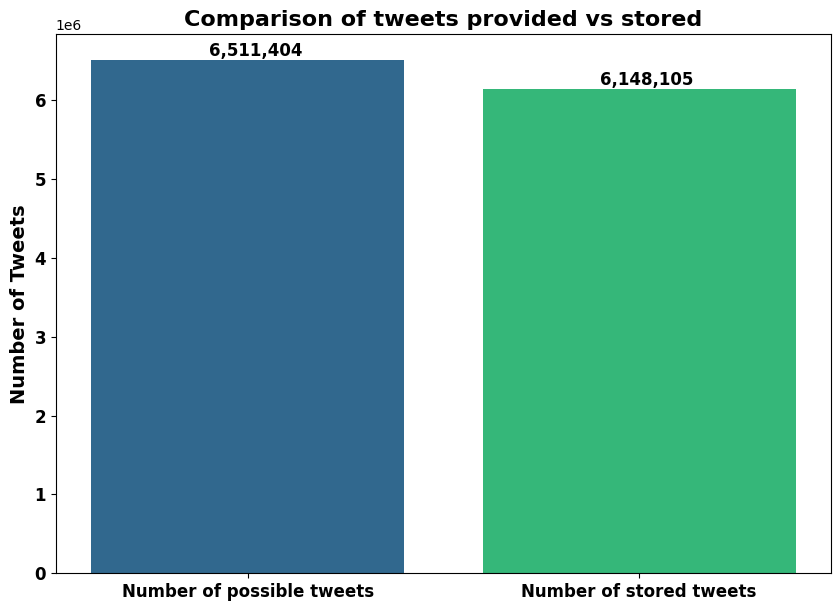

In [8]:
total_lines = 6511404
tweets_right_now = len(test_data)

# Example data
values = [total_lines, tweets_right_now]
labels = ["Number of possible tweets", "Number of stored tweets"]

plt.figure(figsize=(10, 7))
bars = plt.bar(labels, values, color=sns.color_palette("viridis", len(labels)))

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 50000, f'{yval:,}', fontsize=12, weight='bold')

# Customize the chart
plt.title('Comparison of tweets provided vs stored', fontsize=16, weight='bold')
plt.ylabel('Number of Tweets', fontsize=14, weight='bold')
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold');

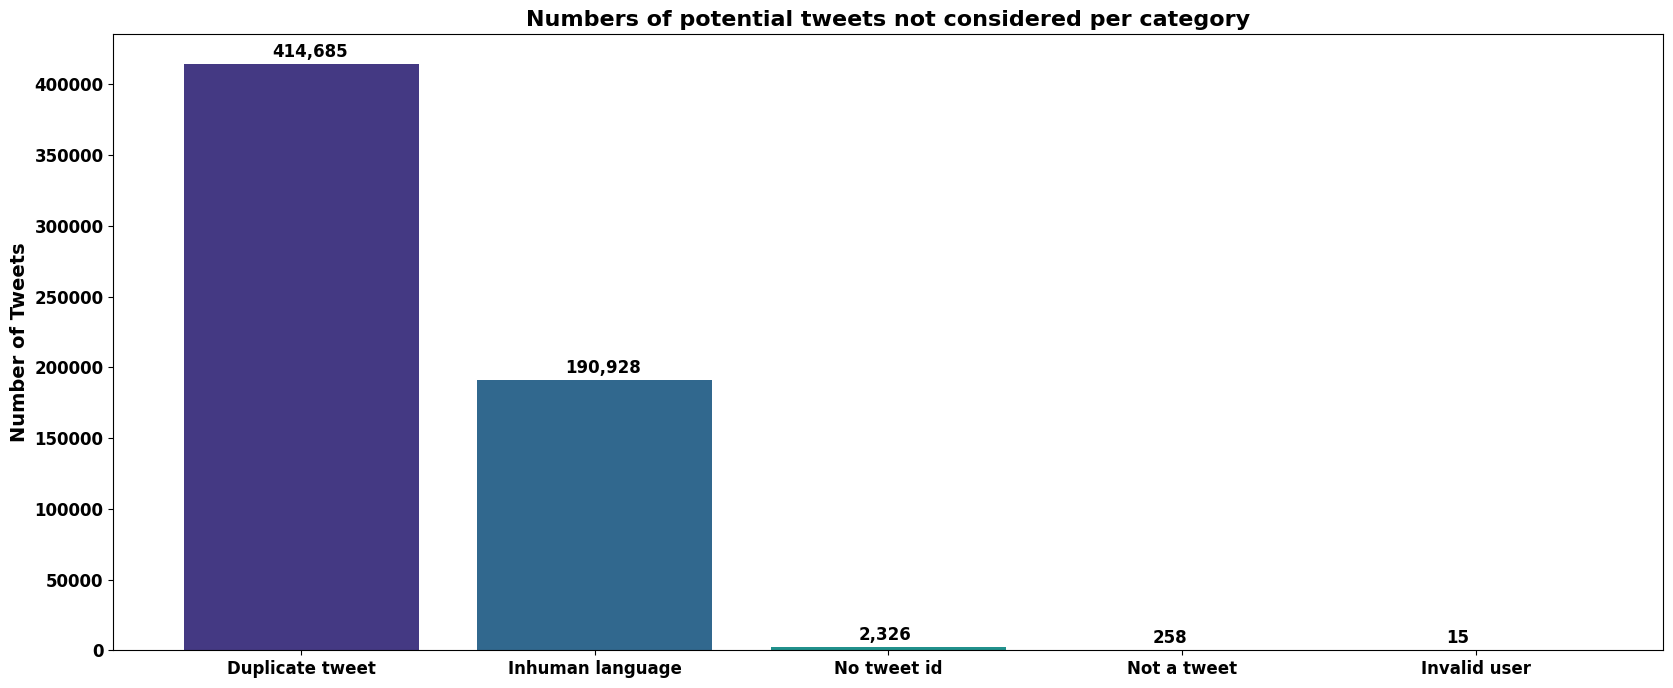

In [9]:
# Example data
data = [258, 414685, 190928, 2326, 15]
labels = ['Not a tweet', 'Duplicate tweet', 'Inhuman language',
          'No tweet id', "Invalid user"]

# Ensure data and labels have the same length
assert len(data) == len(labels), "Data and labels must be the same length."

# Sort the data and labels in decreasing order
sorted_data_labels = sorted(zip(data, labels), reverse=True)
data, labels = zip(*sorted_data_labels)

# Choose a color palette

# Create the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(labels, data, color=sns.color_palette("viridis", len(labels)))

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 5000, f'{yval:,}',
             fontsize=12, weight='bold')

# Customize the chart
plt.title('Numbers of potential tweets not considered per category',
          fontsize=16, weight='bold')
plt.ylabel('Number of Tweets', fontsize=14, weight='bold')
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold');

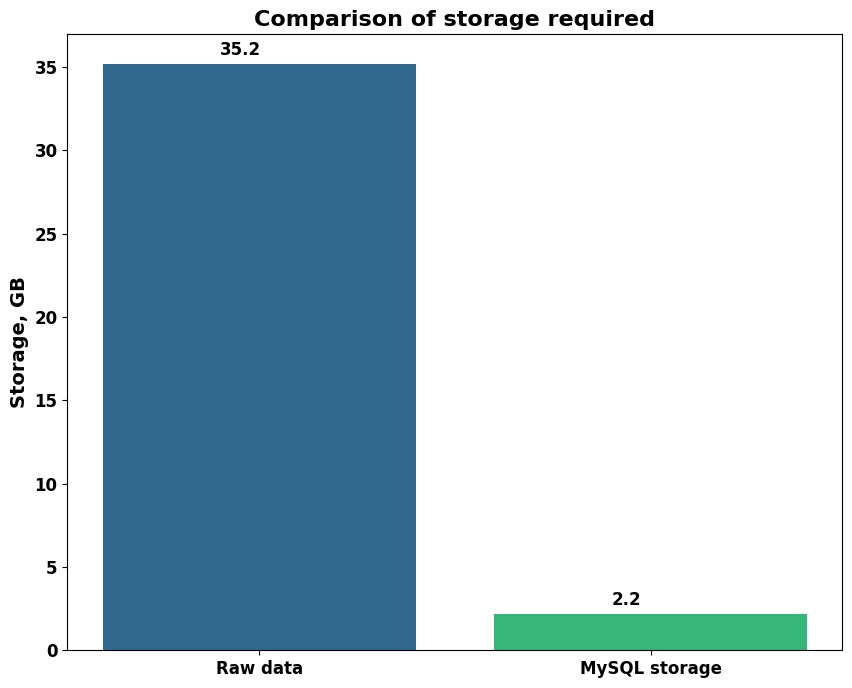

In [10]:
total_lines = 35.2
mysql = 2.2
# sqlite = 1.8

values = [total_lines, mysql]
labels = ["Raw data", "MySQL storage"]

plt.figure(figsize=(10, 8))
bars = plt.bar(labels, values, color=sns.color_palette("viridis", len(labels)))  

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval+0.5, f'{yval:,}',
             fontsize=12, weight='bold')

# Customize the chart
plt.title('Comparison of storage required', fontsize=16, weight='bold')
plt.ylabel('Storage, GB', fontsize=14, weight='bold')
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold');

## Language related

In [11]:
df_lang_distr = test_data.groupby('lang', observed=True)\
    [["user_id"]].count().sort_values('user_id', ascending=False)\
        .rename(columns={"user_id":"Tweets number"})
df_lang_distr.head()

,Tweets number
lang,
en,4450565
es,400248
fr,266447
nl,199921
und,182385


In [12]:
df_top_lang = df_lang_distr.nlargest(5, 'Tweets number')

df_other_lang = df_lang_distr.loc[~df_lang_distr.index.isin(df_top_lang.index)]

df_lang_agg = df_other_lang.sum()
df_lang_agg.name = 'Other languages'

df_lang_agg_final = pd.concat([df_top_lang, df_lang_agg.to_frame().T])
df_lang_agg_final.index.name = 'Language'
df_lang_agg_final.index = df_lang_agg_final.index.map(get_full_language_name)
df_lang_agg_final

,Tweets number
Language,
English,4450565
Spanish,400248
French,266447
Dutch,199921
Undefined Language,182385
Other languages,648539


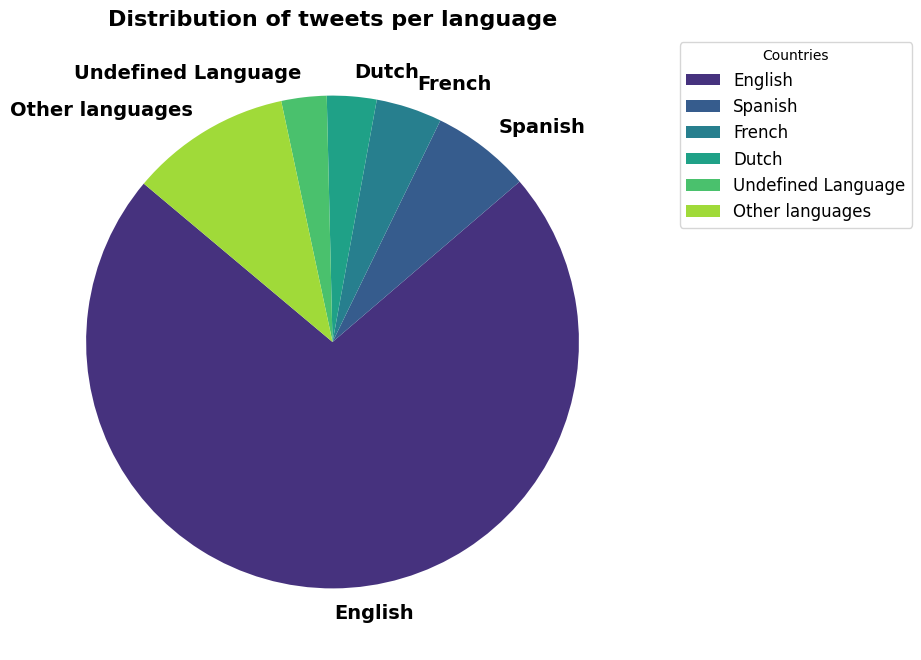

In [13]:
plt.figure(figsize=(10, 8))
plt.pie(df_lang_agg_final["Tweets number"], labels=df_lang_agg_final.index,
        startangle=140, textprops={'fontsize': 14, 'weight': 'bold'},
        colors=sns.color_palette("viridis", len(df_lang_agg_final)))
plt.title('Distribution of tweets per language', fontsize=16, weight='bold')
plt.legend(df_lang_agg_final.index, title="Countries",
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

## Country of origin

In [14]:
df_country_dist = test_data.groupby('country_code', observed=True)\
    [["user_id"]].count().sort_values('user_id', ascending=False)\
        .rename(columns={"user_id":"Tweets number"})
df_country_dist.index = df_country_dist.index.map(get_country_name)
df_country_dist

,Tweets number
country_code,
Unknown Country,5967498
United States,54360
United Kingdom,49487
Australia,8552
Netherlands,6781
...,...
"Micronesia, Federated States of",1
Falkland Islands (Malvinas),1
Dominica,1


In [15]:
df_top_country = df_country_dist.nlargest(1, 'Tweets number')
df_other_country = df_country_dist.loc[~df_country_dist.index.isin(df_top_country.index)]
df_country_agg = df_other_country.sum()

df_country_agg.name = 'Other countries'
df_country_agg_final = pd.concat([df_top_country, df_country_agg.to_frame().T])
df_country_agg_final.index.name = 'Country'
df_country_agg_final

,Tweets number
Country,
Unknown Country,5967498
Other countries,180148


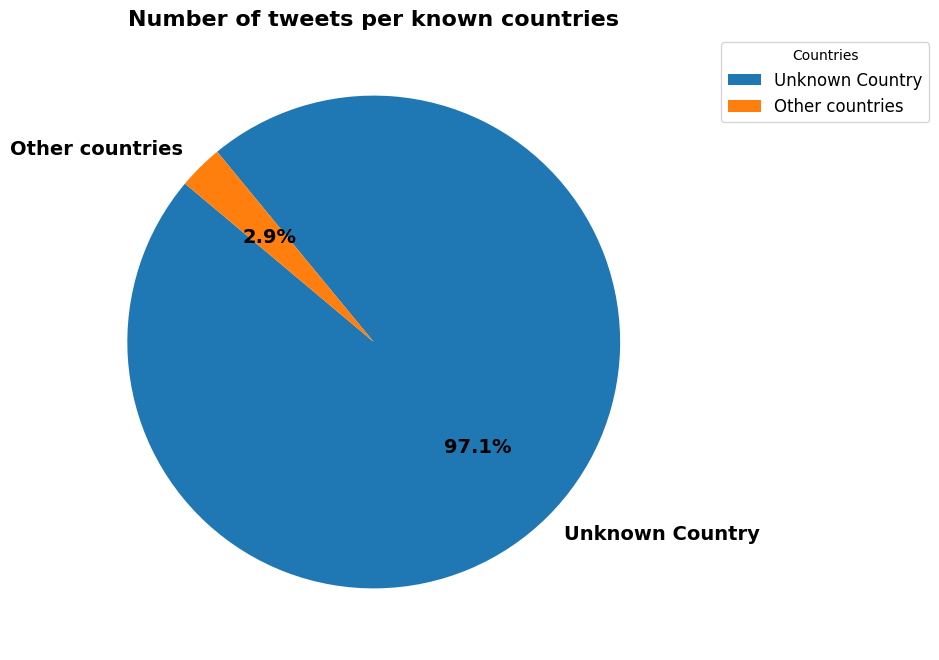

In [16]:
plt.figure(figsize=(10, 8))
plt.pie(df_country_agg_final['Tweets number'], labels=df_country_agg_final.index,
        autopct='%1.1f%%', startangle=140,
        textprops={'fontsize': 14, 'weight': 'bold'})
plt.title("Number of tweets per known countries", fontsize=16, weight='bold')
plt.legend(df_country_agg_final.index, title="Countries",
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [17]:
df_country_known = df_country_dist[df_country_dist.index != "Unknown Country"].copy()

top_10_countries = df_country_known.nlargest(5, 'Tweets number')

other_countries_df = df_country_known.loc[~df_country_known.index.isin(top_10_countries.index)]

other_countries_agg = other_countries_df.sum()
other_countries_agg.name = 'Other countries'


df_top_country_known = df_country_known.nlargest(5, 'Tweets number')
df_other_country_known = df_country_known.loc[~df_country_known.index.isin(df_top_country_known.index)]
df_country_known_agg = df_other_country_known.sum()

df_country_known_agg.name = 'Other countries'
df_country_known_agg_final = pd.concat([df_top_country_known, df_country_known_agg.to_frame().T])
df_country_known_agg_final.index.name = 'Country'
df_country_known_agg_final

,Tweets number
Country,
United States,54360
United Kingdom,49487
Australia,8552
Netherlands,6781
Spain,6613
Other countries,54355


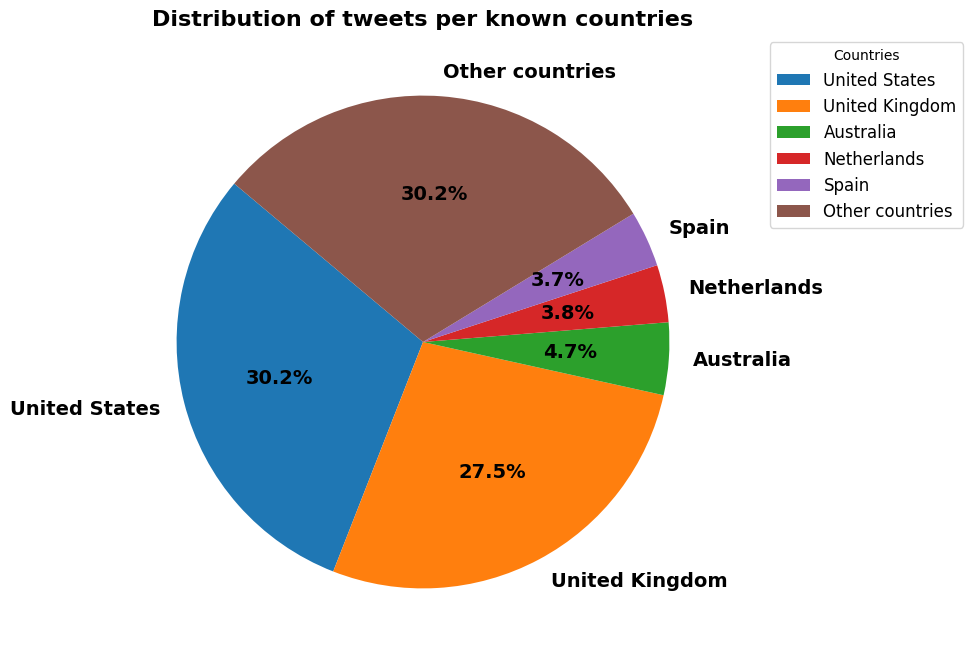

In [18]:
plt.figure(figsize=(10, 8))
plt.pie(df_country_known_agg_final["Tweets number"], labels=df_country_known_agg_final.index,
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14, 'weight': 'bold'}, )
plt.title("Distribution of tweets per known countries", fontsize=16, weight='bold')
plt.legend(df_country_known_agg_final.index, title="Countries",
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

## Tweets from main accounts of the airlines

In [19]:
avia_names = set(COMPANY_NAME_TO_ID.values())

replies_to_avia_companies_df = test_data.loc[test_data['user_id'].apply(
    lambda x: any(x == avia_name for avia_name in avia_names)
    )]
replies_to_avia_companies_df = replies_to_avia_companies_df.reset_index()\
    .groupby("user_id").count()[['tweet_id']]\
        .sort_values('tweet_id', ascending=False).reset_index()
replies_to_avia_companies_df["user_id"] = replies_to_avia_companies_df["user_id"]\
    .apply(lambda user_id: COMPANY_ID_TO_NAME.get(user_id, user_id))
replies_to_avia_companies_df = replies_to_avia_companies_df.set_index("user_id")
replies_to_avia_companies_df

,tweet_id
user_id,
American Air,114626
British Airways,107042
easyJet,54845
Klm,34395
Virgin Atlantic,21712
Ryanair,20403
Lufthansa,13145
Singapore Airlines,12979
Qantas,12174


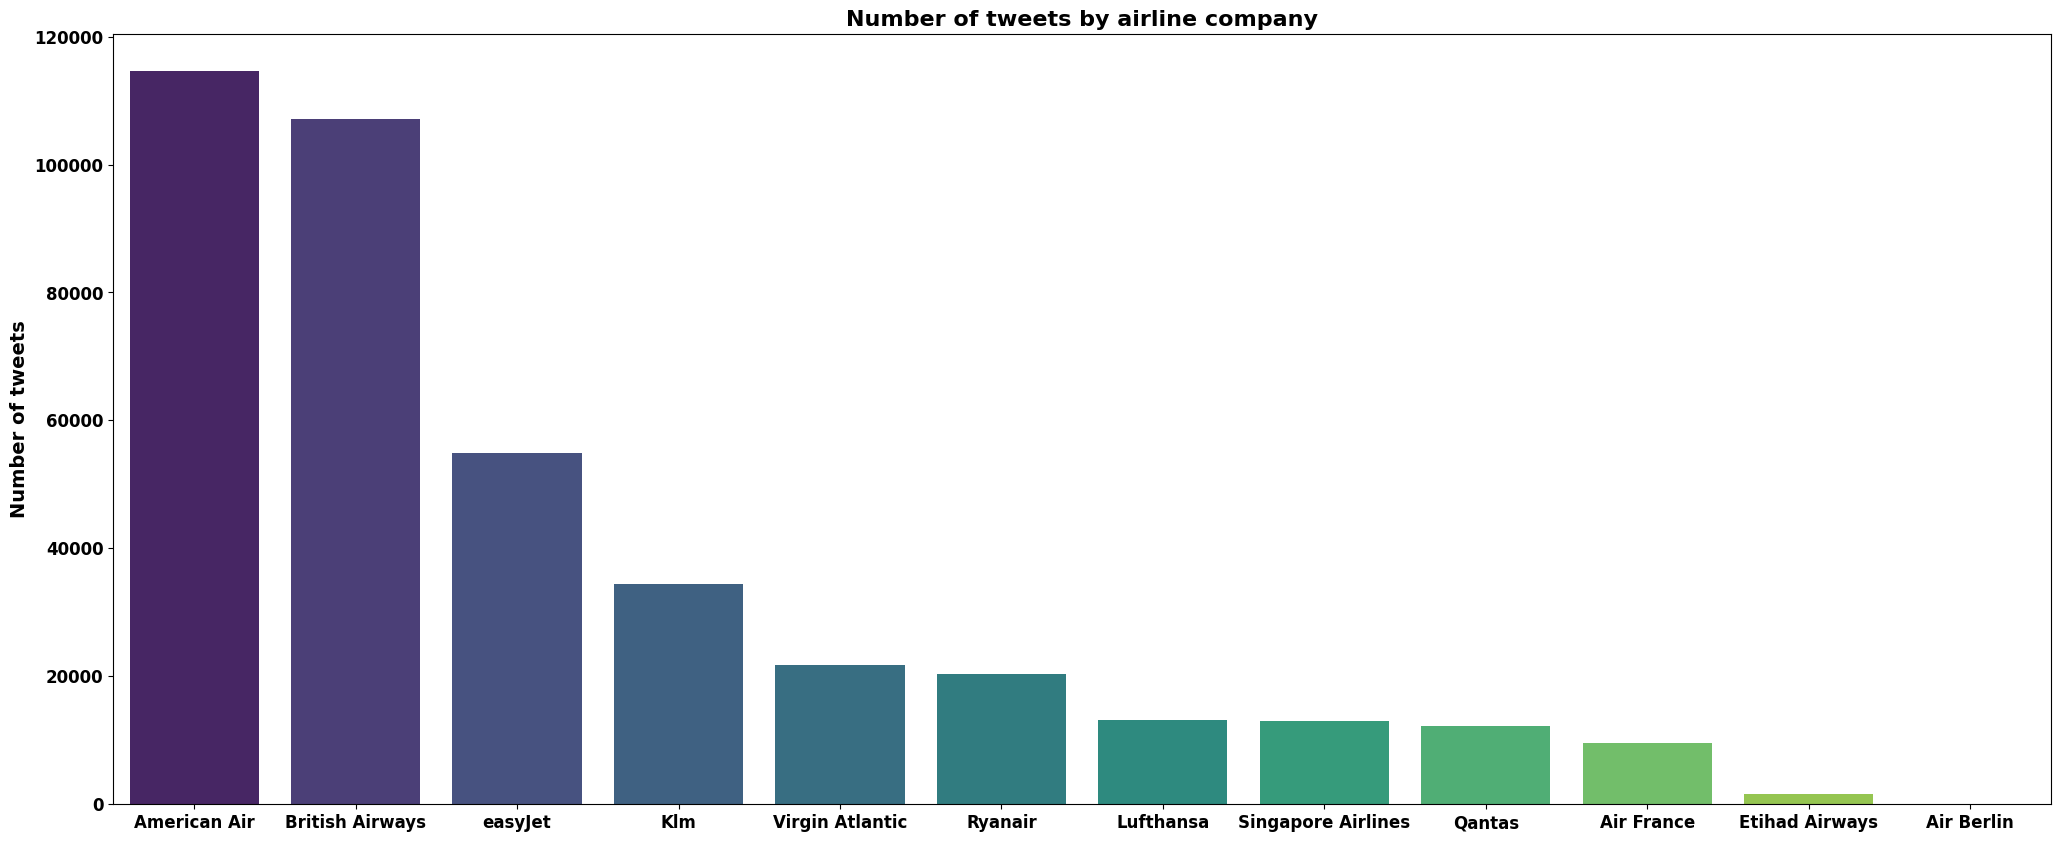

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,10))
sns.barplot(data=replies_to_avia_companies_df, ax=ax, x='user_id', y='tweet_id',
            palette=sns.color_palette("viridis", replies_to_avia_companies_df.index.nunique()),
            hue='user_id', dodge=False)
# Customize the chart
plt.title('Number of tweets by airline company', fontsize=16, weight='bold')
plt.ylabel('Number of tweets', fontsize=14, weight='bold')
plt.xlabel('', fontsize=14, weight='bold')
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold');

## Replies to company posts

In [21]:
df_reply["tweet_creation_time"] = pd.to_datetime(df_reply["tweet_creation_time"])
df_reply["original_tweet_creation_time"] = pd.to_datetime(df_reply["original_tweet_creation_time"])
df_reply["response_time"] = df_reply["tweet_creation_time"] - df_reply["original_tweet_creation_time"]
df_reply

,tweet_creation_time,user_id,original_tweet_id,original_tweet_creation_time,original_user_id,response_time
tweet_id,,,,,,
1131173100454854657,2019-05-22 12:20:57+00:00,415065617,1131063465626427392,2019-05-22 05:05:19+00:00,43775786,0 days 07:15:38
1131173318269259776,2019-05-22 12:21:49+00:00,1582838545,1131114635661324291,2019-05-22 08:28:38+00:00,2886658179,0 days 03:53:11
1131173537388093441,2019-05-22 12:22:42+00:00,839511316712796161,1130939919772209152,2019-05-21 20:54:23+00:00,1000793307688058880,0 days 15:28:19
1131087622661726208,2019-05-22 06:41:18+00:00,38676903,1131068685043548160,2019-05-22 05:26:03+00:00,131494378,0 days 01:15:15
1131173742405660674,2019-05-22 12:23:31+00:00,929369002861907969,1106442403051982848,2019-03-15 06:30:00+00:00,22536055,68 days 05:53:31
...,...,...,...,...,...,...
1244696491580628993,2020-03-30 18:42:23+00:00,2774375013,1244344799647449089,2020-03-29 19:24:53+00:00,806967414193868800,0 days 23:17:30
1244696494881542144,2020-03-30 18:42:24+00:00,1233410199500791809,1244695385978867713,2020-03-30 18:37:59+00:00,501241382,0 days 00:04:25
1244696513437032453,2020-03-30 18:42:28+00:00,1917516697,1244696469233229826,2020-03-30 18:42:18+00:00,1917516697,0 days 00:00:10


In [22]:
df_reply["airline"] = df_reply["user_id"].map(COMPANY_ID_TO_NAME)
df_reply["original_airline"] = df_reply["original_user_id"].map(COMPANY_ID_TO_NAME)
df_reply

,tweet_creation_time,user_id,original_tweet_id,original_tweet_creation_time,original_user_id,response_time,airline,original_airline
tweet_id,,,,,,,,
1131173100454854657,2019-05-22 12:20:57+00:00,415065617,1131063465626427392,2019-05-22 05:05:19+00:00,43775786,0 days 07:15:38,NaN,NaN
1131173318269259776,2019-05-22 12:21:49+00:00,1582838545,1131114635661324291,2019-05-22 08:28:38+00:00,2886658179,0 days 03:53:11,NaN,NaN
1131173537388093441,2019-05-22 12:22:42+00:00,839511316712796161,1130939919772209152,2019-05-21 20:54:23+00:00,1000793307688058880,0 days 15:28:19,NaN,NaN
1131087622661726208,2019-05-22 06:41:18+00:00,38676903,1131068685043548160,2019-05-22 05:26:03+00:00,131494378,0 days 01:15:15,easyJet,NaN
1131173742405660674,2019-05-22 12:23:31+00:00,929369002861907969,1106442403051982848,2019-03-15 06:30:00+00:00,22536055,68 days 05:53:31,NaN,American Air
...,...,...,...,...,...,...,...,...
1244696491580628993,2020-03-30 18:42:23+00:00,2774375013,1244344799647449089,2020-03-29 19:24:53+00:00,806967414193868800,0 days 23:17:30,NaN,NaN
1244696494881542144,2020-03-30 18:42:24+00:00,1233410199500791809,1244695385978867713,2020-03-30 18:37:59+00:00,501241382,0 days 00:04:25,NaN,NaN
1244696513437032453,2020-03-30 18:42:28+00:00,1917516697,1244696469233229826,2020-03-30 18:42:18+00:00,1917516697,0 days 00:00:10,NaN,NaN


In [23]:
# Convert datetime and timedelta columns
df_reply['response_time'] = pd.to_timedelta(df_reply['response_time'])

# Calculate average response time per airline
average_response_time_airline = df_reply[df_reply['airline'].notnull()]\
    .groupby('airline')['response_time'].mean()

# Calculate average response time for others users to react to each airline
average_response_time_reactions = df_reply[df_reply['original_airline'].notnull()]\
    .groupby('original_airline')['response_time'].mean()

# Combine the results into one DataFrame for plotting
df_airline_response = pd.DataFrame({
    'Airline Response Time': average_response_time_airline.reindex(
        average_response_time_airline.index.union(average_response_time_reactions.index)
        ),
    'User Reaction Time': average_response_time_reactions.reindex(
        average_response_time_airline.index.union(average_response_time_reactions.index)
        )
})
df_airline_response.index.name = "Airline"
df_airline_response

,Airline Response Time,User Reaction Time
Airline,,
Air Berlin,NaT,716 days 03:10:05.400000
Air France,0 days 08:02:55.074472711,2 days 05:34:45.345842385
American Air,0 days 01:06:41.651944004,1 days 18:00:05.984518073
British Airways,0 days 11:24:37.307932638,2 days 06:15:05.222098683
Etihad Airways,0 days 00:51:11.413102820,4 days 04:47:41.111450381
Klm,0 days 05:56:05.219118182,8 days 11:23:05.968993839
Lufthansa,0 days 00:36:35.936642768,2 days 10:47:36.649731515
Qantas,0 days 06:04:42.893429419,1 days 17:25:04.909705648
Ryanair,0 days 08:46:06.739004933,0 days 17:16:26.644364300


In [24]:
df_airline_response_plot = df_airline_response.dropna().copy()
df_airline_response_plot['Airline Response Time, hours'] = df_airline_response_plot['Airline Response Time'].dt.total_seconds() / 3600
df_airline_response_plot['User Reaction Time, days'] = df_airline_response_plot['User Reaction Time'].dt.total_seconds() / 86.400

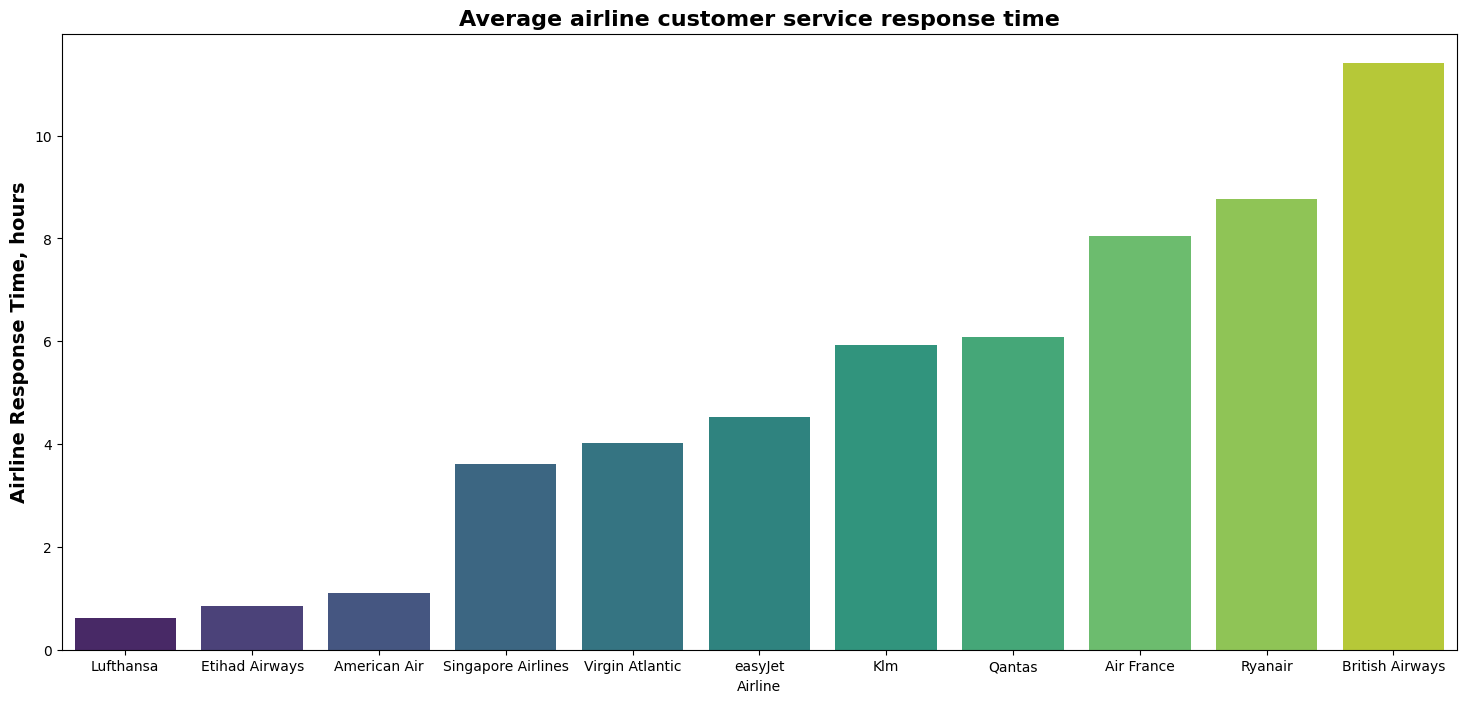

In [25]:
fig, ax = plt.subplots(nrows=1, figsize=(18, 8))
sns.barplot(df_airline_response_plot.sort_values('Airline Response Time, hours'),
            x='Airline', y='Airline Response Time, hours', ax=ax,
            palette=sns.color_palette("viridis", df_airline_response_plot.index.nunique()),
            hue='Airline', dodge=False)
ax.set_title('Average airline customer service response time',
             fontsize=16, weight='bold')
ax.set_ylabel('Airline Response Time, hours', fontsize=14, weight='bold');

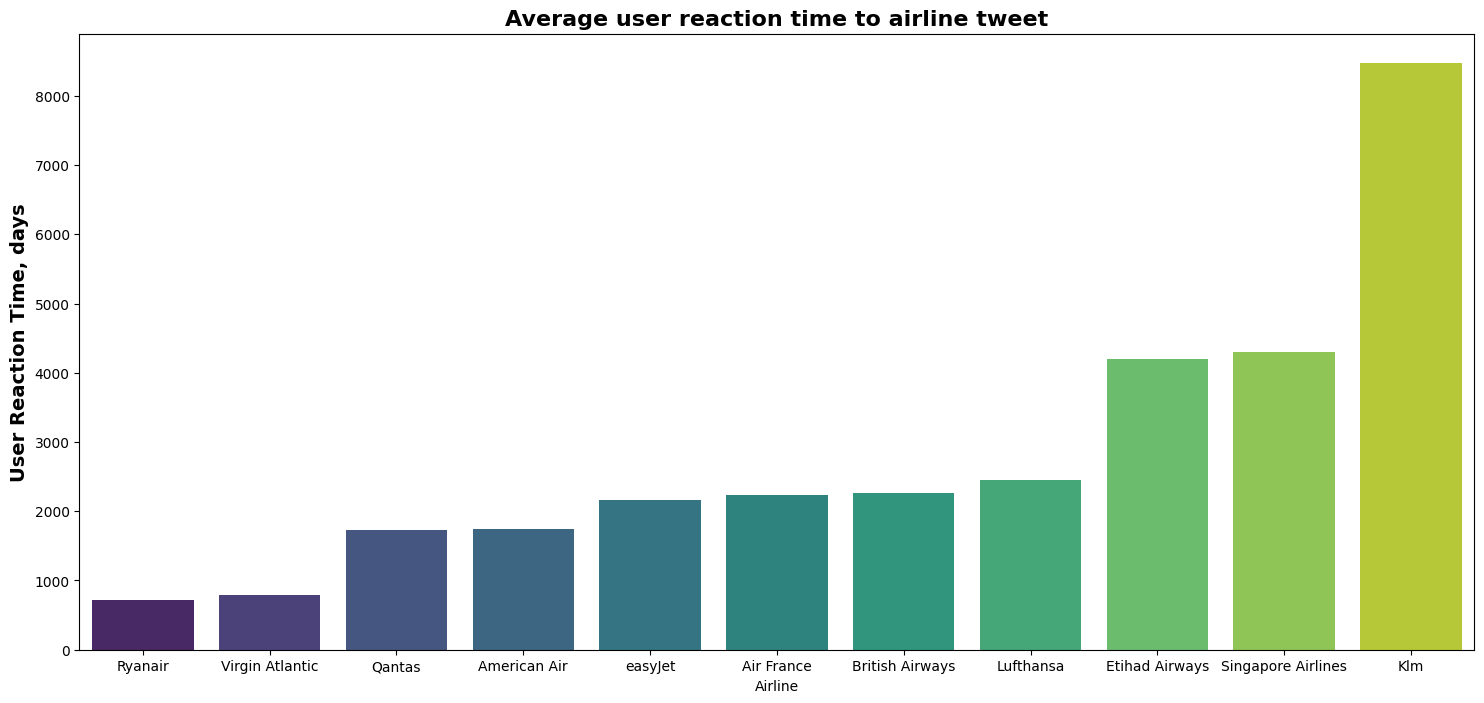

In [26]:
fig, ax = plt.subplots(nrows=1, figsize=(18, 8))
sns.barplot(df_airline_response_plot.sort_values('User Reaction Time, days'),
            x='Airline', y='User Reaction Time, days', ax=ax,
            palette=sns.color_palette("viridis", df_airline_response_plot.index.nunique()),
            hue='Airline', dodge=False)
ax.set_title('Average user reaction time to airline tweet', fontsize=16, weight='bold')
ax.set_ylabel('User Reaction Time, days', fontsize=14, weight='bold');

In [27]:
df_reply_luft = df_reply.groupby("airline")
# df_reply_luft.reset_index().set_index("original_tweet_id")
df_reply_luft.describe()

response_time                             \
                           count                       mean   
airline                                                       
Air France                  9198  0 days 08:02:55.074472711   
American Air              111008  0 days 01:06:41.651944004   
British Airways           103383  0 days 11:24:37.307932638   
Etihad Airways              1099  0 days 00:51:11.413102820   
Klm                        32932  0 days 05:56:05.219118182   
Lufthansa                  12832  0 days 00:36:35.936642768   
Qantas                     11795  0 days 06:04:42.893429419   
Ryanair                    19054  0 days 08:46:06.739004933   
Singapore Airlines         12790  0 days 03:36:21.617122752   
Virgin Atlantic            20572  0 days 04:01:17.255881781   
easyJet                    53682  0 days 04:32:00.228009388   

                                                                \
                                          std              min   
airline                                                          
Air France          6 days 13:54:38.871653392  0 days 00:00:00   
American Air        2 days 17:20:22.061610988  0 days 00:00:03   
British Airways     1 days 04:40:36.053735526  0 days 00:00:14   
Etihad Airways      0 days 03:51:01.582465260  0 days 00:00:00   
Klm                 9 days 07:41:19.287256336  0 days 00:00:00   
Lufthansa           0 days 04:18:59.045045858  0 days 00:00:00   
Qantas              0 days 16:59:47.901646319  0 days 00:00:00   
Ryanair             0 days 17:39:38.125659786  0 days 00:00:00   
Singapore Airlines  0 days 18:59:13.884946588  0 days 00:00:03   
Virgin Atlantic     2 days 16:47:09.095354295  0 days 00:00:04   
easyJet             0 days 09:57:15.094447458  0 days 00:00:20   

                                                                    \
                                       25%                     50%   
airline                                                              
Air France          0 days 00:13:51.250000         0 days 00:42:24   
American Air               0 days 00:10:29         0 days 00:26:59   
British Airways            0 days 00:23:08         0 days 02:05:28   
Etihad Airways             0 days 00:08:08         0 days 00:17:17   
Klm                        0 days 00:07:51         0 days 00:14:44   
Lufthansa                  0 days 00:03:30         0 days 00:07:06   
Qantas              0 days 00:26:45.500000         0 days 01:45:08   
Ryanair             0 days 00:03:57.250000  0 days 00:35:59.500000   
Singapore Airlines         0 days 00:42:35         0 days 01:07:32   
Virgin Atlantic            0 days 00:05:53         0 days 00:15:27   
easyJet                    0 days 00:07:59         0 days 00:33:28   

                                                                
                                       75%                 max  
airline                                                         
Air France                 0 days 02:42:11   622 days 21:25:18  
American Air               0 days 00:49:19   795 days 17:34:11  
British Airways     0 days 08:26:15.500000    26 days 05:55:39  
Etihad Airways      0 days 00:34:16.500000     3 days 11:17:33  
Klm                        0 days 00:32:09  1178 days 23:36:24  
Lufthansa                  0 days 00:16:08    12 days 05:24:05  
Qantas                     0 days 05:06:08    21 days 17:13:20  
Ryanair                    0 days 12:21:15    20 days 19:27:54  
Singapore Airlines         0 days 02:21:13    29 days 07:14:38  
Virgin Atlantic     0 days 01:02:04.500000   208 days 17:42:26  
easyJet                    0 days 03:26:03     8 days 04:19:23

## Companies' activity and popularity in social media

In [28]:
df_airlines_popularity = test_data[test_data['user_id']\
    .apply(lambda x: any(x == avia_name for avia_name in avia_names))]\
        .groupby("user_id")\
            .agg(
                retweet_count=("retweet_count", "sum"),
                favorite_count=("favorite_count", "sum"),
                reply_count=("reply_count", "sum"),
                quote_count=("quote_count", "sum"),
            )
df_airlines_popularity.index = df_airlines_popularity.index.map(
    lambda user_id: COMPANY_ID_TO_NAME[user_id]
    )
df_airlines_popularity.index.name = "Airlines"
df_airlines_popularity

,retweet_count,favorite_count,reply_count,quote_count
Airlines,,,,
Air France,289,1240,302,54
Lufthansa,2985,20326,897,619
Ryanair,32645,50261,11780,6036
British Airways,36194,129151,14882,6862
Virgin Atlantic,1491,8845,698,328
Qantas,39482,114832,3944,9503
American Air,9801,29049,2669,1017
Singapore Airlines,4420,13884,887,708
Air Berlin,1308,3334,212,170


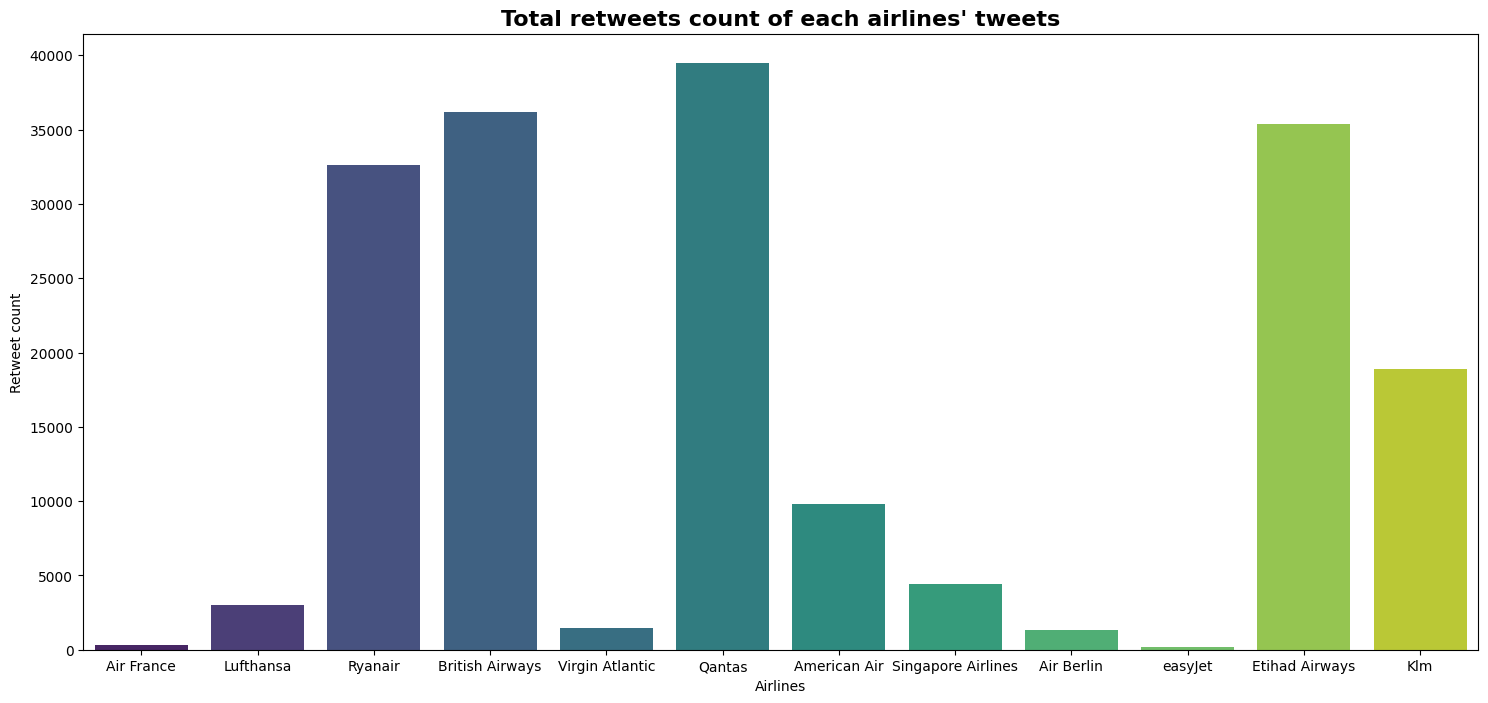

In [29]:
fig, ax = plt.subplots(nrows=1, figsize=(18, 8))
sns.barplot(df_airlines_popularity, x='Airlines', y="retweet_count", ax=ax,
            palette=sns.color_palette("viridis", df_airlines_popularity.index.nunique()),
            hue='Airlines', dodge=False)
ax.set_title("Total retweets count of each airlines' tweets", fontsize=16, weight='bold')
ax.set_ylabel("Retweet count");

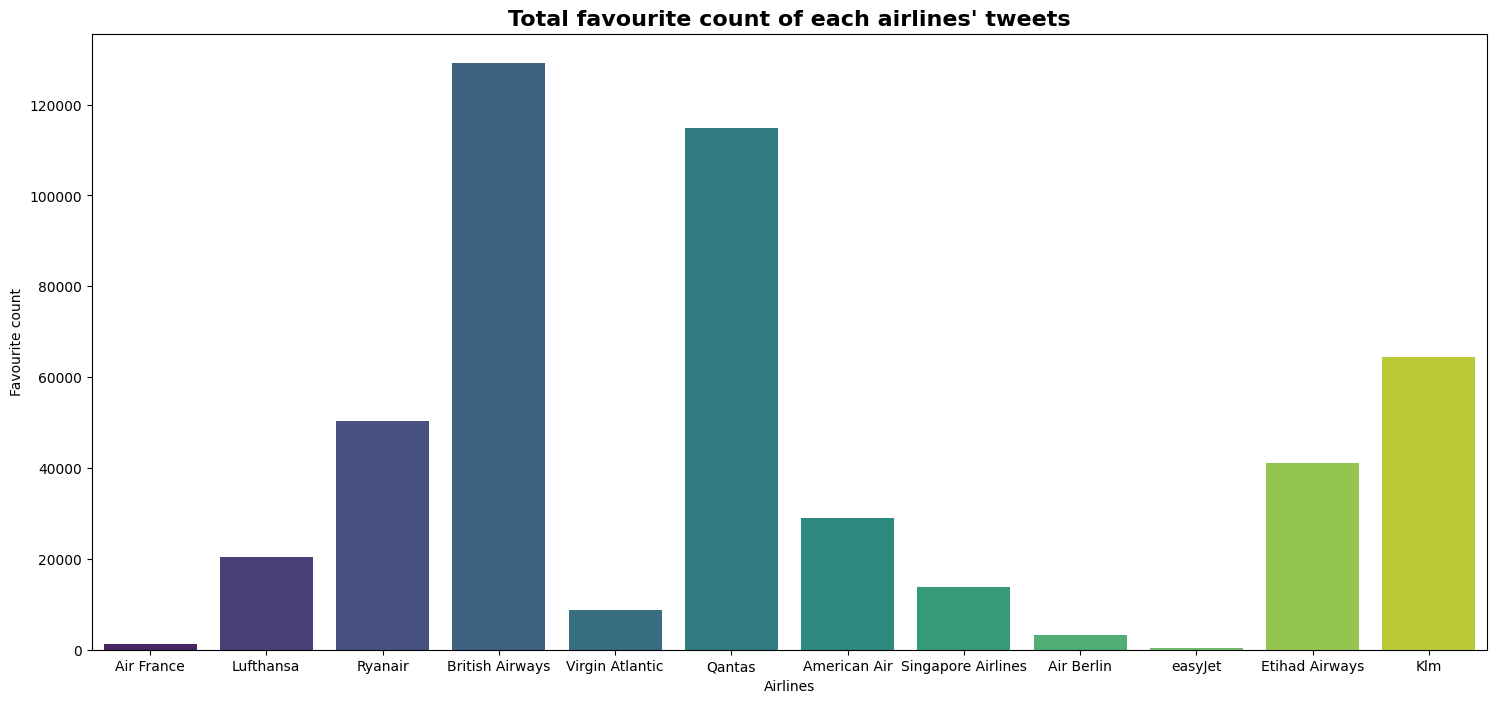

In [30]:
fig, ax = plt.subplots(nrows=1, figsize=(18, 8))
sns.barplot(df_airlines_popularity, x='Airlines', y="favorite_count", ax=ax,
            palette=sns.color_palette("viridis", df_airlines_popularity.index.nunique()),
            hue='Airlines', dodge=False)
ax.set_title("Total favourite count of each airlines' tweets", fontsize=16, weight='bold')
ax.set_ylabel("Favourite count");

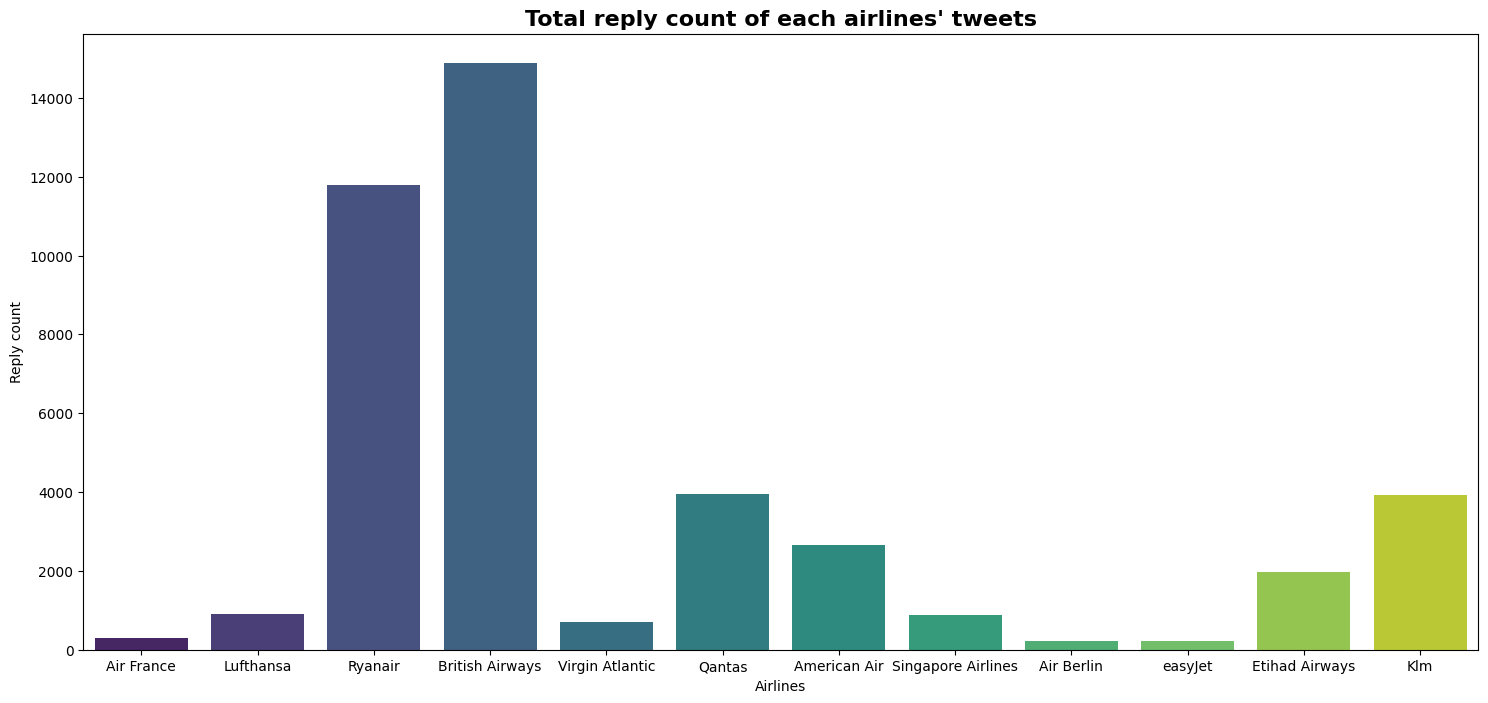

In [31]:
fig, ax = plt.subplots(nrows=1, figsize=(18, 8))
sns.barplot(df_airlines_popularity, x='Airlines', y="reply_count", ax=ax,
            palette=sns.color_palette("viridis", df_airlines_popularity.index.nunique()),
            hue='Airlines', dodge=False)
ax.set_title("Total reply count of each airlines' tweets", fontsize=16, weight='bold')
ax.set_ylabel("Reply count");

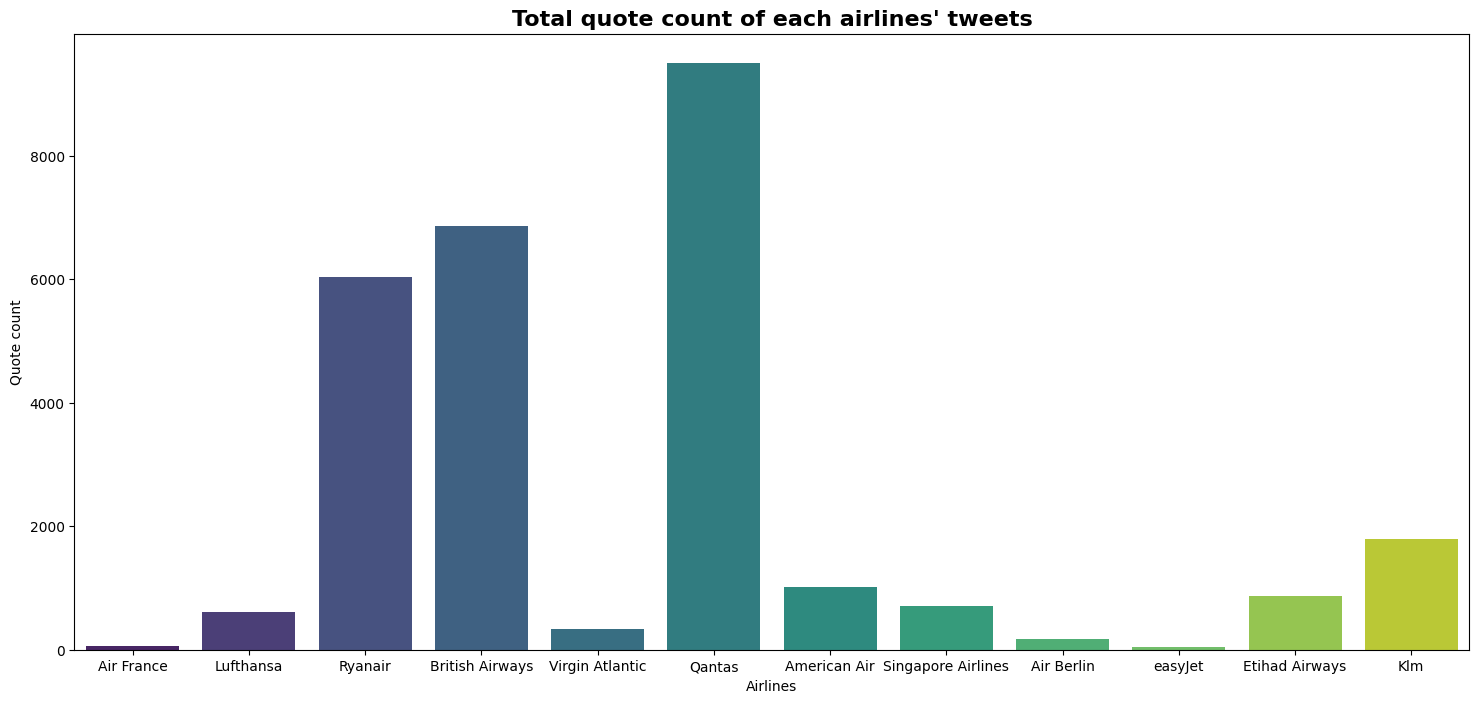

In [32]:
fig, ax = plt.subplots(nrows=1, figsize=(18, 8))
sns.barplot(df_airlines_popularity, x='Airlines', y="quote_count", ax=ax,
            palette=sns.color_palette("viridis", df_airlines_popularity.index.nunique()),
            hue='Airlines', dodge=False)
ax.set_title("Total quote count of each airlines' tweets", fontsize=16, weight='bold')
ax.set_ylabel("Quote count");

## Information regarding users

In [33]:
df_users = test_data.groupby("user_id")
df_users = df_users.agg(
    user_creation_time=("user_creation_time", "min"),
    verified=("verified", "min"),
    followers_count=("followers_count", "min"),
    friends_count=("friends_count", "min"),
    statuses_count=("statuses_count", "min"),
    default_profile=("default_profile", "min"),
    default_profile_image=("default_profile_image", "max"),
    first_tweet=("tweet_creation_time", "min"),
    last_tweet=("tweet_creation_time", "max"),
    possibly_sensitive=("possibly_sensitive", "sum"),
    favorite_count=("favorite_count", "sum"),
    retweet_count=("retweet_count", "sum"),
    reply_count=("reply_count", "sum"),
    quote_count=("quote_count", "sum"),
    lang=("lang", "first")
)
df_users.head()

,user_creation_time,verified,followers_count,friends_count,statuses_count,default_profile,default_profile_image,first_tweet,last_tweet,possibly_sensitive,favorite_count,retweet_count,reply_count,quote_count,lang
user_id,,,,,,,,,,,,,,,
1000000043833810945,2018-05-25 13:06:04+00:00,False,241,133,32610,True,False,2019-08-07 22:05:33+00:00,2019-08-07 22:05:33+00:00,0,0,0,0,0,en
1000000704612917249,2018-05-25 13:08:41+00:00,False,60,88,1256,True,False,2019-08-08 12:57:51+00:00,2019-08-08 12:57:51+00:00,0,0,0,0,0,en
100000075,2009-12-28 17:19:41+00:00,False,511,188,5713,False,False,2019-07-17 14:35:00+00:00,2019-11-21 20:50:58+00:00,0,0,0,0,0,en
1000000830001512449,2018-05-25 13:09:11+00:00,False,408,737,7837,True,False,2020-02-29 07:12:36+00:00,2020-02-29 09:37:10+00:00,0,0,0,0,0,en
1000001587006210050,2018-05-25 13:12:12+00:00,False,82,207,5361,True,False,2020-03-26 20:56:13+00:00,2020-03-26 20:56:13+00:00,0,0,0,0,0,ja


In [34]:
df_users.describe()

,followers_count,friends_count,statuses_count,possibly_sensitive,favorite_count,retweet_count,reply_count,quote_count
count,2.344991e+06,2.344991e+06,2.344991e+06,2.344991e+06,2.344991e+06,2.344991e+06,2.344991e+06,2.344991e+06
mean,4.678533e+03,8.962324e+02,1.946763e+04,1.486061e-02,3.735050e+01,1.091323e+01,2.218999e+00,3.454232e+00
std,2.328479e+05,5.731196e+03,4.860118e+04,1.110587e+00,4.787811e+03,1.388133e+03,6.709553e+02,5.054106e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.500000e+01,1.380000e+02,8.050000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.180000e+02,3.440000e+02,4.550000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.000000e+02,8.120000e+02,1.787400e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.138688e+08,4.541583e+06,6.944156e+06,1.441000e+03,3.602848e+06,1.398490e+06,7.731310e+05,5.297480e+05


### Custom user "trustworthiness" classification

,verified
verified,
Not Verified,2313647
Verified,31344


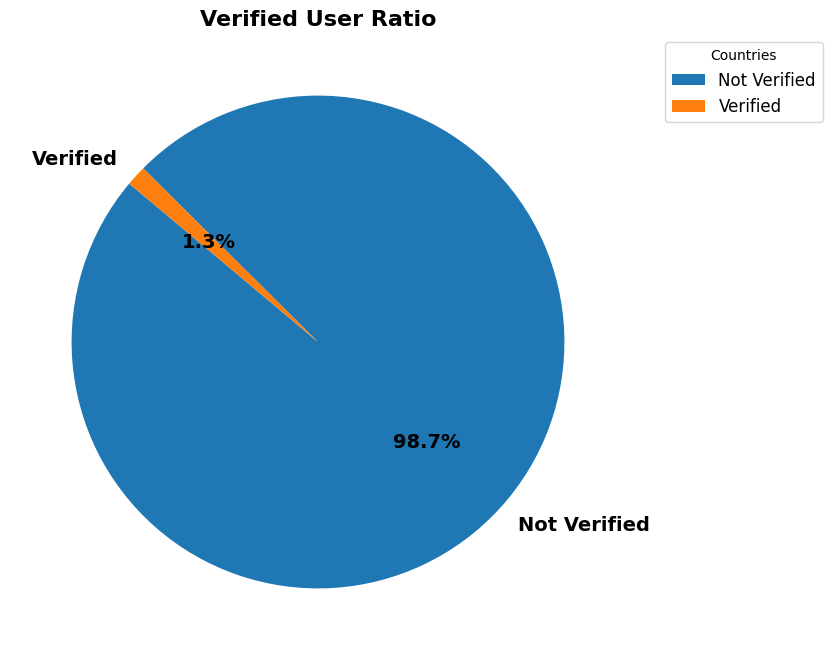

In [35]:
df_verified = df_users.groupby("verified").agg(verified=("user_creation_time", "count"))
df_verified.index = df_verified.index.map(
    lambda x: {True: "Verified", False: "Not Verified"}[x]
    )

plt.figure(figsize=(10, 8))
plt.pie(df_verified["verified"], labels=df_verified.index, autopct='%1.1f%%',
        startangle=140, textprops={'fontsize': 14, 'weight': 'bold'})
plt.title("Verified User Ratio", fontsize=16, weight='bold')
plt.legend(df_verified.index, title="Countries", bbox_to_anchor=(1.05, 1),
           loc='upper left', fontsize=12)
df_verified

,default_profile
default_profile,
Unique Profile,1015199
Default Profile,1329792


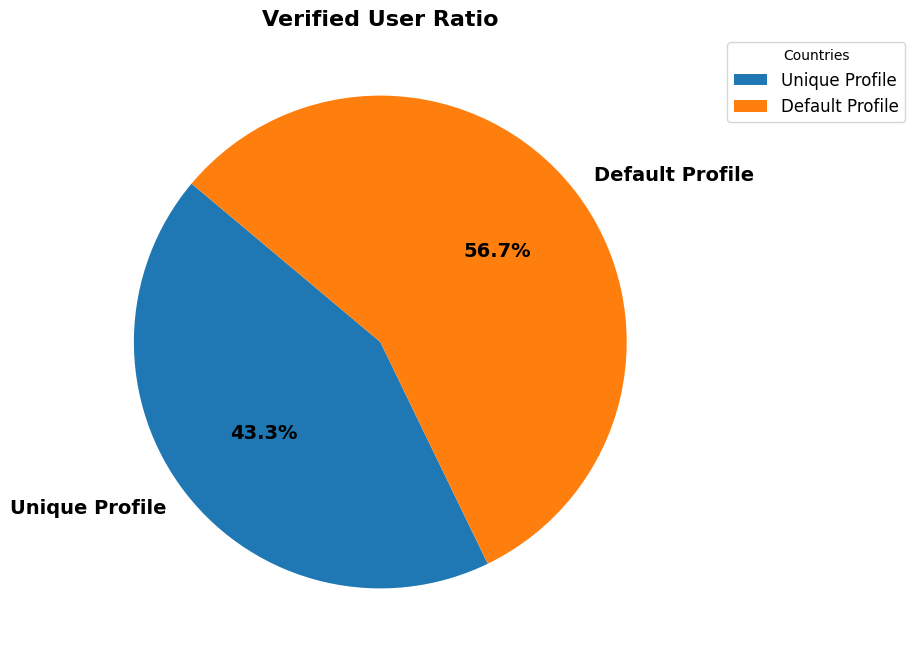

In [36]:
default_profile = df_users.groupby("default_profile").agg(default_profile=("user_creation_time", "count"))
default_profile.index = default_profile.index.map(lambda x: {True: "Default Profile", False: "Unique Profile"}[x])

plt.figure(figsize=(10, 8))
plt.pie(default_profile["default_profile"], labels=default_profile.index,
        autopct='%1.1f%%', startangle=140,
        textprops={'fontsize': 14, 'weight': 'bold'})
plt.title("Verified User Ratio", fontsize=16, weight='bold')
plt.legend(default_profile.index, title="Countries", bbox_to_anchor=(1.05, 1),
           loc='upper left', fontsize=12)
default_profile

## Tweets information

,user_id
possibly_sensitive,
Not Sensitive,6113257
Sensitive,34848


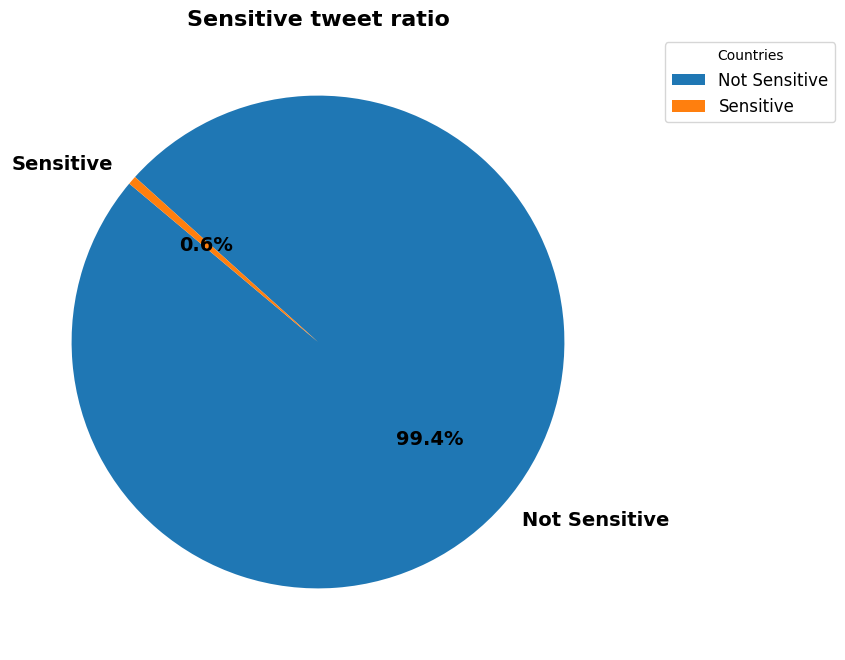

In [37]:
df_sensitive = test_data.groupby("possibly_sensitive")[["user_id"]].count()
df_sensitive.index = df_sensitive.index.map(lambda x: {True: "Sensitive", False: "Not Sensitive"}[x])

plt.figure(figsize=(10, 8))
plt.pie(df_sensitive["user_id"], labels=df_sensitive.index, autopct='%1.1f%%',
        startangle=140, textprops={'fontsize': 14, 'weight': 'bold'})
plt.title("Sensitive tweet ratio", fontsize=16, weight='bold')
plt.legend(df_sensitive.index, title="Countries", bbox_to_anchor=(1.05, 1),
           loc='upper left', fontsize=12)
df_sensitive

# Conversations

In [38]:
convo_special = test_data.sort_values("tweet_creation_time", ascending=False)[["user_id", "replied_tweet_id", "quoted_status_id"]]
convo_special

,user_id,replied_tweet_id,quoted_status_id
tweet_id,,,
1244696713765564416,56784613,None,None
1244696713350217728,1223576386432126976,None,None
1244696710447800320,109284383,None,None
1244696708983984131,246520593,None,None
1244696703690772485,278698748,None,1244398934522392576
...,...,...,...
773181150,10812972,None,None
773176947,10812972,None,None
773176924,10812972,None,None


In [39]:
# v1
from tqdm import tqdm
from collections import defaultdict

class TrieNode:
    def __init__(self):
        self.children = defaultdict(TrieNode)
        self.is_end = False

class Trie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, conversation):
        node = self.root
        for tweet_id in conversation:
            node = node.children[tweet_id]
        node.is_end = True

    def is_subset(self, conversation):
        node = self.root
        for tweet_id in conversation:
            if tweet_id not in node.children:
                return False
            node = node.children[tweet_id]
        return True



def trace_conversation(start_tweet_id, tweet_dict):
    convo = []
    current_tweet_id = start_tweet_id
    users_in_conversation = set()
    local_processed_tweet_ids = set()  # Local set to track the current conversation
    while current_tweet_id:
        if current_tweet_id not in tweet_dict or current_tweet_id in local_processed_tweet_ids:
            break
        tweet_info = tweet_dict[current_tweet_id]
        convo.append(current_tweet_id)
        users_in_conversation.add(tweet_info['user_id'])
        local_processed_tweet_ids.add(current_tweet_id)
        if len(users_in_conversation) > 2:
            return None  # More than two users, not an exclusive conversation
        current_tweet_id = tweet_info['replied_tweet_id']
    return convo[::-1] if len(users_in_conversation) == 2 else None


def extract_and_filter_conversations(df):
    tweet_dict = df.to_dict('index')
    conversations = []
    trie = Trie()  # Initialize trie for subset checks

    # Start tracing conversations from tweets that are replies
    for tweet_id in tqdm(df[df['replied_tweet_id'].notnull()].index,
                         desc="Extracting all conversations"):
        if conversation := trace_conversation(tweet_id, tweet_dict):
            if not trie.is_subset(conversation):
                trie.insert(conversation)
                conversations.append(conversation)

    return conversations

In [40]:
conversations = extract_and_filter_conversations(convo_special)

Extracting all conversations: 100%|██████████| 1795409/1795409 [00:07<00:00, 225486.63it/s]


In [41]:
conversations

[['1244344799647449089', '1244696491580628993'],
 ['1244593729312362497', '1244696406570475525'],
 ['1242875007270891523', '1244696352090656770'],
 ['1244584879095939073', '1244696279806087172'],
 ['1244693824519184392', '1244696279197847555'],
 ['1243532085131743232', '1244696235019304960'],
 ['1244398934522392576', '1244696145772904455'],
 ['1244542518987014144', '1244542697366532096', '1244696138512556033'],
 ['1244695110639632386', '1244696125833175041'],
 ['1244542518987014144', '1244696104341471234'],
 ['1244690997419880449', '1244695731597959175', '1244696054827794438'],
 ['1239668797218402305',
  '1241034899156545542',
  '1241147545096765443',
  '1242202731919675397',
  '1242339956263182336',
  '1244683643416698880',
  '1244689590549647361',
  '1244695969918222338'],
 ['1241498515039272960', '1244695952151240705'],
 ['1244694028899307522', '1244695930475098115'],
 ['1244694632220549123', '1244695856177123329'],
 ['1244670465999806466', '1244682844733083648', '124469583332236083

In [42]:
len(conversations)

864593

In [43]:
data = []
for convo_num, convo in enumerate(conversations, start=1):
    data.extend((convo_num, tweet_id) for tweet_id in convo)
# Create a DataFrame
df_conversations = pd.DataFrame(data, columns=['Conversation', 'Tweet_ID'])

# Set MultiIndex
df_conversations

,Conversation,Tweet_ID
0,1,1244344799647449089
1,1,1244696491580628993
2,2,1244593729312362497
3,2,1244696406570475525
4,3,1242875007270891523
...,...,...
2206483,864591,451125255294443521
2206484,864592,430790355962052608
2206485,864592,430792524043931648
2206486,864593,248528541157834752


In [44]:

# Merge the conversation DataFrame with the test_data DataFrame
df_conversations_full = df_conversations.merge(test_data, left_on='Tweet_ID', right_index=True, how='left')

# Set the MultiIndex again with Conversation and Tweet_ID
df_conversations_full.set_index(['Conversation', 'Tweet_ID'], inplace=True)
df_conversations_full


user_id  \
Conversation Tweet_ID                                  
1            1244344799647449089  806967414193868800   
             1244696491580628993          2774375013   
2            1244593729312362497           281046179   
             1244696406570475525  907026711010836480   
3            1242875007270891523            22536055   
...                                              ...   
864591       451125255294443521             22536055   
864592       430790355962052608             64327804   
             430792524043931648             22536055   
864593       248528541157834752             19911051   
             248529937198366720            399494759   

                                        user_creation_time  verified  \
Conversation Tweet_ID                                                  
1            1244344799647449089 2016-12-08 21:03:19+00:00     False   
             1244696491580628993 2014-09-18 09:48:49+00:00     False   
2            1244593729312362497 2011-04-12 14:30:18+00:00      True   
             1244696406570475525 2017-09-10 23:43:14+00:00     False   
3            1242875007270891523 2009-03-02 21:23:05+00:00      True   
...                                                    ...       ...   
864591       451125255294443521  2009-03-02 21:23:05+00:00      True   
864592       430790355962052608  2009-08-10 03:34:27+00:00     False   
             430792524043931648  2009-03-02 21:23:05+00:00      True   
864593       248528541157834752  2009-02-02 15:17:02+00:00      True   
             248529937198366720  2011-10-27 15:47:03+00:00     False   

                                  followers_count  friends_count  \
Conversation Tweet_ID                                              
1            1244344799647449089               17            307   
             1244696491580628993              548           1400   
2            1244593729312362497           235796           1623   
             1244696406570475525                1             15   
3            1242875007270891523          1556816         106922   
...                                           ...            ...   
864591       451125255294443521           1556816         106922   
864592       430790355962052608               217            573   
             430792524043931648           1556816         106922   
864593       248528541157834752            246933            789   
             248529937198366720               626           2099   

                                  statuses_count  default_profile  \
Conversation Tweet_ID                                               
1            1244344799647449089              10             True   
             1244696491580628993           14273             True   
2            1244593729312362497          157514            False   
             1244696406570475525               5             True   
3            1242875007270891523         2096661            False   
...                                          ...              ...   
864591       451125255294443521          2096661            False   
864592       430790355962052608             5675             True   
             430792524043931648          2096661            False   
864593       248528541157834752            18849            False   
             248529937198366720             1126            False   

                                  default_profile_image  \
Conversation Tweet_ID                                     
1            1244344799647449089                  False   
             1244696491580628993                  False   
2            1244593729312362497                  False   
             1244696406570475525                  False   
3            1242875007270891523                  False   
...                                                 ...   
864591       451125255294443521                   False   
864592       430790355962052608                   False   
      

In [45]:
airline_conversation = df_conversations_full.loc[df_conversations_full.index.get_level_values('Conversation').isin(df_conversations_full[df_conversations_full['user_id'] == COMPANY_NAME_TO_ID["Lufthansa"]].index.get_level_values('Conversation'))]
airline_conversation

user_id        user_creation_time  \
Conversation Tweet_ID                                                    
144          1244684192040071173    62555545 2009-08-03 16:35:21+00:00   
             1244688444162486273   124476322 2010-03-19 14:30:32+00:00   
             1244689066567794688    62555545 2009-08-03 16:35:21+00:00   
145          1244685953983225857   562252389 2012-04-24 16:49:01+00:00   
             1244689043952209921   124476322 2010-03-19 14:30:32+00:00   
...                                      ...                       ...   
864459       1095473044573700096  1339792290 2013-04-09 17:56:30+00:00   
864465       1090912573304774662   124476322 2010-03-19 14:30:32+00:00   
             1090913775417479168    18631142 2009-01-05 13:13:10+00:00   
864471       1083376699780280321   478699784 2012-01-30 15:32:40+00:00   
             1083381532071469058   124476322 2010-03-19 14:30:32+00:00   

                                  verified  followers_count  friends_count  \
Conversation Tweet_ID                                                        
144          1244684192040071173     False               61             10   
             1244688444162486273      True           427154             31   
             1244689066567794688     False               61             10   
145          1244685953983225857     False              310            531   
             1244689043952209921      True           427154             31   
...                                    ...              ...            ...   
864459       1095473044573700096     False               43            149   
864465       1090912573304774662      True           427154             31   
             1090913775417479168     False               92            405   
864471       1083376699780280321     False              605            981   
             1083381532071469058      True           427154             31   

                                  statuses_count  default_profile  \
Conversation Tweet_ID                                               
144          1244684192040071173             178             True   
             1244688444162486273          102269            False   
             1244689066567794688             178             True   
145          1244685953983225857            5504             True   
             1244689043952209921          102269            False   
...                                          ...              ...   
864459       1095473044573700096             192            False   
864465       1090912573304774662          102269            False   
             1090913775417479168            4111             True   
864471       1083376699780280321            1383            False   
             1083381532071469058          102269            False   

                                  default_profile_image  \
Conversation Tweet_ID                                     
144          1244684192040071173                  False   
             1244688444162486273                  False   
             1244689066567794688                  False   
145          1244685953983225857                  False   
             1244689043952209921                  False   
...                                                 ...   
864459       1095473044573700096                  False   
864465       1090912573304774662                  False   
             1090913775417479168                  False   
864471       1083376699780280321                  False   
             1083381532071469058                  False   

                                       tweet_creation_time  \
Conversation Tweet_ID                                        
144          1244684192040071173 2020-03-30 17:53:31+00:00   
             1244688444162486273 2020-03-30 18:10:24+00:00   
             1244689066567794688 2020-03-30 18:12:53+00:00   
145          1244685953983225857 2020-03-30 18:00:31+00:00   
             12446890

In [46]:
airline_conversation = airline_conversation.reset_index()
airline_conversation['New_Conversation'] = pd.factorize(airline_conversation['Conversation'])[0] + 1
airline_conversation = airline_conversation.set_index(['New_Conversation', 'Tweet_ID'])
airline_conversation = airline_conversation.sort_index(level='New_Conversation')
airline_conversation

Conversation     user_id  \
New_Conversation Tweet_ID                                        
1                1244684192040071173           144    62555545   
                 1244688444162486273           144   124476322   
                 1244689066567794688           144    62555545   
2                1244685953983225857           145   562252389   
                 1244689043952209921           145   124476322   
...                                            ...         ...   
12912            1095473044573700096        864459  1339792290   
12913            1090912573304774662        864465   124476322   
                 1090913775417479168        864465    18631142   
12914            1083376699780280321        864471   478699784   
                 1083381532071469058        864471   124476322   

                                            user_creation_time  verified  \
New_Conversation Tweet_ID                                                  
1                1244684192040071173 2009-08-03 16:35:21+00:00     False   
                 1244688444162486273 2010-03-19 14:30:32+00:00      True   
                 1244689066567794688 2009-08-03 16:35:21+00:00     False   
2                1244685953983225857 2012-04-24 16:49:01+00:00     False   
                 1244689043952209921 2010-03-19 14:30:32+00:00      True   
...                                                        ...       ...   
12912            1095473044573700096 2013-04-09 17:56:30+00:00     False   
12913            1090912573304774662 2010-03-19 14:30:32+00:00      True   
                 1090913775417479168 2009-01-05 13:13:10+00:00     False   
12914            1083376699780280321 2012-01-30 15:32:40+00:00     False   
                 1083381532071469058 2010-03-19 14:30:32+00:00      True   

                                      followers_count  friends_count  \
New_Conversation Tweet_ID                                              
1                1244684192040071173               61             10   
                 1244688444162486273           427154             31   
                 1244689066567794688               61             10   
2                1244685953983225857              310            531   
                 1244689043952209921           427154             31   
...                                               ...            ...   
12912            1095473044573700096               43            149   
12913            1090912573304774662           427154             31   
                 1090913775417479168               92            405   
12914            1083376699780280321              605            981   
                 1083381532071469058           427154             31   

                                      statuses_count  default_profile  \
New_Conversation Tweet_ID                                               
1                1244684192040071173             178             True   
                 1244688444162486273          102269            False   
                 1244689066567794688             178             True   
2                1244685953983225857            5504             True   
                 1244689043952209921          102269            False   
...                                              ...              ...   
12912            1095473044573700096             192            False   
12913            1090912573304774662          102269            False   
                 1090913775417479168            4111             True   
12914            1083376699780280321            1383            False   
                 1083381532071469058          102269            False   

                                      default_profile_image  \
New_Conversation Tweet_ID                                     
1                1244684192040071173                  False   
                 1244688444162486273                  False   
                 1244689066567794688               